In [412]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import uncertainties
from uncertainties import ufloat, unumpy
from uncertainties.umath import sqrt
from scipy.odr import ODR, Model, RealData
from scipy.optimize import fsolve, curve_fit
from matplotlib.ticker import AutoMinorLocator, LogLocator, MaxNLocator
from scipy import constants
from scipy.stats import poisson, norm
import probscale
from scipy import stats

## Data Loader

In [306]:
def load_data(path):
    np.set_printoptions(suppress=True, precision=10)
    data_list = sorted(glob.glob(path))
    data_np = []
    for i in data_list:
        data = pd.read_csv(i, sep=',')
        data_np.append(data.to_numpy())
    return data_np

## Plateu voltage

In [307]:
path_voltage = '/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C46/*.csv'
data1_2, voltage, events = load_data(path=path_voltage)

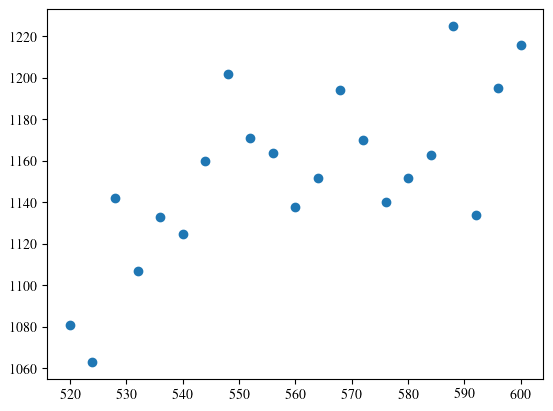

In [308]:
plt.scatter(voltage[:,0][6:], voltage[:,1][6:])

In [309]:
mean_voltage = np.mean([min(voltage[:,0][6:]), max(voltage[:,0][6:])])
mean_count = np.mean(voltage[:,1][6:])

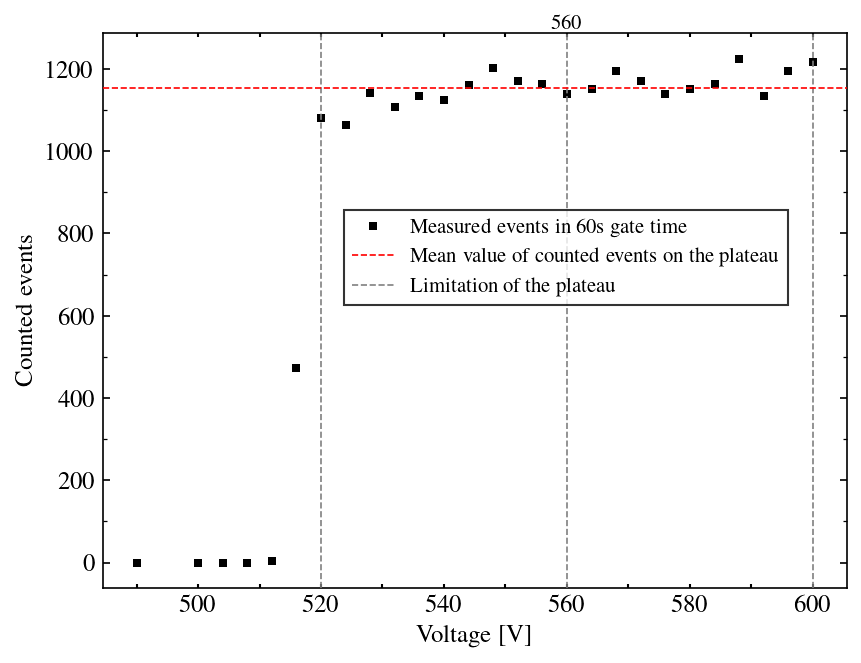

In [310]:
fig, ax = plt.subplots(dpi=150)

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True


ax.errorbar(voltage[:,0], voltage[:,1],
            capsize=4,
            xerr=None, yerr=None,
            ecolor='black',
            elinewidth=.6,
            capthick=.6,
            markersize=4, fmt="s",
            markeredgecolor='none', c="black",
            label=f'Measured events in 60s gate time',
            zorder=2)

ax.axvline(voltage[:,0][6],
           color='grey',
           linestyle='--',
           linewidth=0.8,
           zorder=3,
           label='Limitation of the plateau')
ax.axvline(voltage[:,0][-1],
           color='grey',
           linestyle='--',
           linewidth=0.8,
           zorder=3)
ax.axvline(mean_voltage,
           color='grey',
           linestyle='--',
           linewidth=0.8,
           zorder=3)
ax.axhline(mean_count,
           color='red',
           linestyle='--',
           linewidth=0.8,
           zorder=3,
           label='Mean value of counted events on the plateau')
# ax.set_xlim(5, 8.5)
plt.annotate(f'{mean_voltage:.0f}', xy=(mean_voltage, ax.get_ylim()[1]), ha='center', va='bottom')

ax.set_ylabel('Counted events', fontsize=12)
ax.set_xlabel('Voltage [V]', fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(axis='x', which='both',direction='in', labelsize=12, width=1, length=2, bottom=True, top=True)
ax.tick_params(axis='y', which='both',direction='in', labelsize=12, left=True, right=True)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]  

plt.legend([handles[idx] for idx in order],
        [labels[idx] for idx in order],
        loc="upper left",
        bbox_to_anchor=(0.31, 0.7),
        fancybox=False,
        edgecolor='black',
        fontsize=10)
plt.show()

# fig.savefig('/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C46/Plots/plateau_voltage.pdf')

In [311]:
bins, counts = np.unique(events[:,2], return_counts=True)
combined_counts = np.sum(counts[-3:])
new_bins = np.delete(bins, (-1,-2), axis=0)
new_counts = np.delete(counts, (-1,-2), axis=0)
new_counts[-1] = combined_counts


## 2.5 Distributions

### Calcuating mean and standart deviation (Tor time 10s)

In [312]:
probs = counts / np.sum(counts)
mean = np.sum(bins * probs)
std_dev = np.sqrt(np.sum((bins-mean)**2 * probs))
std_err = std_dev / np.sqrt(np.sum(counts))
print(f'Mean: {mean:.2f} ± {std_err:.2f}')
print(f'Std. deviation: {std_dev}')


Mean: 10.75 ± 0.10
Std. deviation: 3.1789216694372726


### Poisson distribution

In [377]:
lam = mean
x = np.arange(0, 30)
pmf_counts = poisson.pmf(x, lam) * np.sum(counts)

combined_pmf_rigth = np.sum(pmf_counts[-12:])
combined_pmf_left = np.sum(pmf_counts[:3])
new_x = np.delete(x, np.arange(len(x)-11, len(x)), axis=0)
new_x = np.delete(new_x, (0,1), axis=0)
new_pmf = np.delete(pmf_counts, np.arange(len(x)-11, len(x)), axis=0)
new_pmf = np.delete(new_pmf, (0,1), axis=0)


new_pmf[-1] = combined_pmf_rigth
new_pmf[0] = combined_pmf_left

new_x = np.append(new_x, new_x[-1]+1)
new_x = np.concatenate(([1], new_x))
new_pmf = np.append(new_pmf, new_pmf[-1])
new_pmf = np.concatenate(([new_pmf[0]], new_pmf))


### Normal distribuation

In [378]:
pdf_counts = norm.pdf(x, lam, std_dev) * np.sum(counts)

combined_pdf_rigth = np.sum(pdf_counts[-12:])
combined_pdf_left = np.sum(pdf_counts[:3])

new_pdf = np.delete(pdf_counts, np.arange(len(x)-11, len(x)), axis=0)
new_pdf = np.delete(new_pdf, (0,1), axis=0)

new_pdf[-1] = combined_pdf_rigth
new_pdf[0] = combined_pdf_left

new_pdf = np.append(new_pdf, new_pdf[-1]) #parameter 2
new_pdf = np.concatenate(([new_pdf[0]], new_pdf))

### Plot

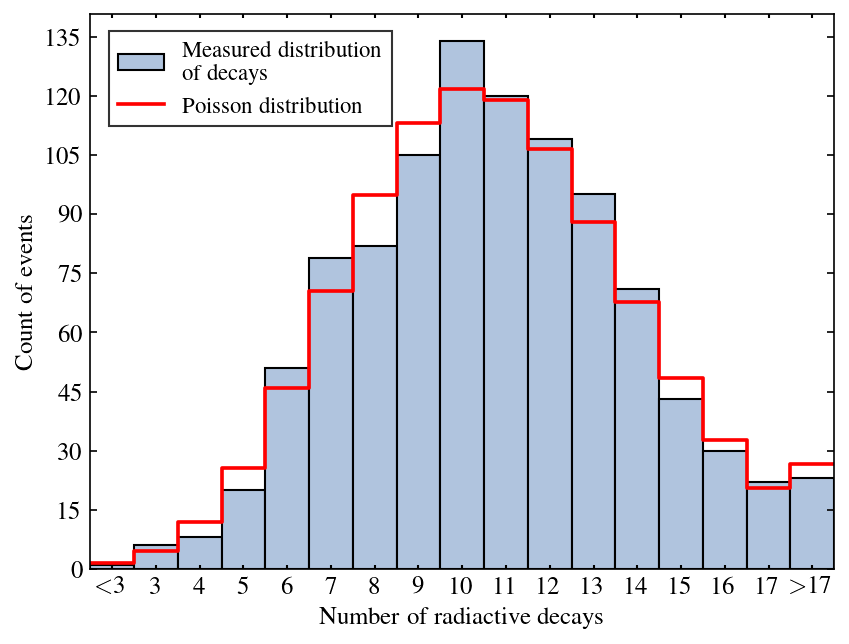

In [387]:
fig, ax = plt.subplots(dpi=150)

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True

bin_list = [r'$\small{<}3$','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17',r'$\small{>}17$']
bins_widths = 1

ax.bar(new_bins, new_counts,
       width=bins_widths,
       alpha=1,
       edgecolor='black',
       facecolor='lightsteelblue',
       label='Measured distribution\n of decays')

# ax.bar(new_x, new_pmf,
#        width=bins_widths,
#        alpha=.5,
#        edgecolor='black',
#        facecolor='red')
ax.step(new_x, new_pmf,
        where='mid', c='red',
        linestyle='-', linewidth=1.75,
        label='Poisson distribution')

ax.set_xlim(1.5, 18.5)
ax.set_xticks(np.arange(2,19,1))
ax.set_xticklabels(bin_list)
ax.set_ylabel('Count of events', fontsize=12)
ax.set_xlabel('Number of radiactive decays', fontsize=12)
# ax.xaxis.set_minor_locator(AutoMinorLocator(2))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_xticks(range(1,21))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', which='both',direction='in', labelsize=12, width=1, length=2, bottom=True, top=True)
ax.tick_params(axis='y', which='both',direction='in', labelsize=12, left=True, right=True)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]  

plt.legend([handles[idx] for idx in order],
        [labels[idx] for idx in order],
        loc="upper left",
        bbox_to_anchor=(0.01, 0.99),
        fancybox=False,
        edgecolor='black',
        fontsize=11)
plt.show()

# fig.savefig('/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C46/Plots/poisson10s.pdf')

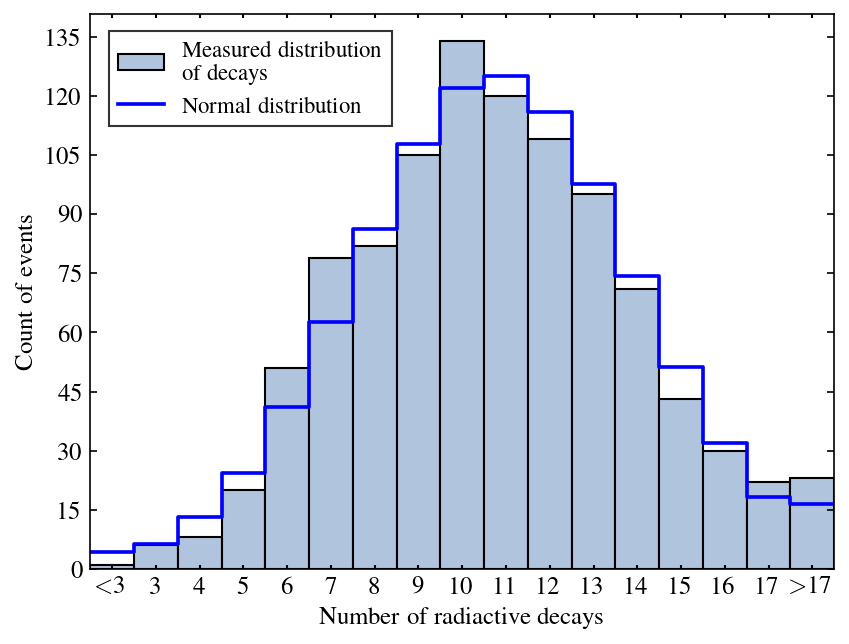

In [386]:
fig, ax = plt.subplots(dpi=150)

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True

bin_list = [r'$\small{<}3$','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17',r'$\small{>}17$']
bins_widths = 1

ax.bar(new_bins, new_counts,
       width=bins_widths,
       alpha=1,
       edgecolor='black',
       facecolor='lightsteelblue',
       label='Measured distribution\n of decays')

# ax.bar(new_x, new_pmf,
#        width=bins_widths,
#        alpha=.5,
#        edgecolor='black',
#        facecolor='red')
ax.step(new_x, new_pdf,
        where='mid', c='blue',
        linestyle='-', linewidth=1.75,
        label='Normal distribution')

ax.set_xlim(1.5, 18.5)
ax.set_xticks(np.arange(2,19,1))
ax.set_xticklabels(bin_list)
ax.set_ylabel('Count of events', fontsize=12)
ax.set_xlabel('Number of radiactive decays', fontsize=12)
# ax.xaxis.set_minor_locator(AutoMinorLocator(2))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_xticks(range(1,21))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', which='both',direction='in', labelsize=12, width=1, length=2, bottom=True, top=True)
ax.tick_params(axis='y', which='both',direction='in', labelsize=12, left=True, right=True)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]  

plt.legend([handles[idx] for idx in order],
        [labels[idx] for idx in order],
        loc="upper left",
        bbox_to_anchor=(0.01, 0.99),
        fancybox=False,
        edgecolor='black',
        fontsize=11)
plt.show()

# fig.savefig('/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C46/Plots/normal10s.pdf')

### Normal distribution testing

In [382]:
probs_cum = np.cumsum(probs)
xes = norm.ppf(probs_cum, loc=lam, scale=std_dev)
theo_cdf = norm.cdf(bins, lam, std_dev)

In [383]:
x_norm = np.linspace(0,21,1000)
norm_ideal = norm.cdf(x_norm, lam, std_dev)

In [384]:
normal = norm(loc=lam, scale=std_dev)
probs_cum
stats.pearsonr(probs_cum, theo_cdf)

PearsonRResult(statistic=0.997304583595906, pvalue=9.896406728581105e-21)

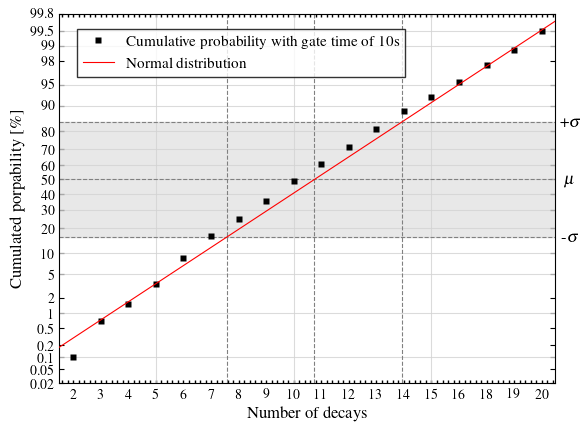

In [410]:
fig, ax = plt.subplots(dpi=100)

plt.rcParams["font.family"] = "times"
plt.rcParams["text.usetex"] = True


bin_list = ['2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','18','19','20']
ax.set_xticks(np.arange(2,20,1))
ax.set_xticklabels(bin_list)

x_lines = [5,10,15,20]
y_lines = [.1,1,5,10,20,30,40,50,60,70,80,90,95,99,99.5]
for x in x_lines:
    ax.axvline(x, color='lightgray', linestyle='-', alpha=.8, linewidth=.8)
for y in y_lines:
    ax.axhline(y, color='lightgray', linestyle='-', alpha=.8, linewidth=.8)
for i in [mean-std_dev, mean, mean+std_dev]:
    ax.axvline(i, color='gray', linestyle='--', alpha=1, linewidth=.8)
for i in [norm.cdf(mean-std_dev, lam, std_dev) * 100, norm.cdf(mean, lam, std_dev) * 100, norm.cdf(mean+std_dev, lam, std_dev) * 100]:
    ax.axhline(i, color='gray', linestyle='--', alpha=1, linewidth=.8)

ax.text(20, 50, r'$\mu$', ha='center', va='center', fontsize=12)
ax.text(20, norm.cdf(mean-std_dev, lam, std_dev) * 100, r'-$\sigma$', ha='center', va='center', fontsize=12)
ax.text(20, norm.cdf(mean+std_dev, lam, std_dev) * 100, r'+$\sigma$', ha='center', va='center', fontsize=12)

ax.fill_between(np.linspace(0,21,1000), norm.cdf(mean-std_dev, lam, std_dev) * 100, norm.cdf(mean+std_dev, lam, std_dev) * 100, color='lightgray', alpha=0.5)

ax.set_yscale('prob', dist=normal)
ax.errorbar(bins[:-1], probs_cum[:-1] * 100,
            capsize=4,
            xerr=None, yerr=None,
            ecolor='black',
            elinewidth=.6,
            capthick=.6,
            markersize=4, fmt="s",
            markeredgecolor='none', c="black",
            label=f'Cumulative probability with gate time of 10s',
            zorder=2)
ax.plot(x_norm, norm_ideal * 100,
        c='red',
        linewidth=.8,
        label='Normal distribution',
        zorder=3)
ax.set_ylim(0.02, 99.8)
ax.set_xlim(1.5, 19.5)
ax.set_ylabel(r'Cumulated porpability [$\%$]', fontsize=12)
ax.set_xlabel('Number of decays', fontsize=12)
ax.tick_params(axis='x', which='both',direction='in', labelsize=10, width=1, length=2, bottom=True, top=True)
ax.tick_params(axis='y', which='both',direction='in', labelsize=10, left=True, right=True)

ax.xaxis.set_minor_locator(AutoMinorLocator(5))

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]  

plt.legend([handles[idx] for idx in order],
        [labels[idx] for idx in order],
        loc="upper left",
        bbox_to_anchor=(0.02, 0.98),
        fancybox=False,
        edgecolor='black',
        fontsize=11)
plt.show()

# fig.savefig('/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C46/Plots/cumdist.pdf')

In [420]:
mean_graphic = ufloat(10.75, 0.05)
std_dev_graphic = mean_graphic - ufloat(7.55, 0.05)
std_calc_graphic = sqrt(mean_graphic)

print(f'Mean exact: {mean}')
print(f'Mean grapfic: {mean_graphic:.3f}')
print(f'Std exact: {std_dev}')
print(f'Std graphic: {std_dev_graphic:.3f}')
print(f'Std sqrt mean: {std_calc_graphic:.4f}')


Mean exact: 10.749749749749752
Mean grapfic: 10.750+/-0.050
Std exact: 3.1789216694372726
Std graphic: 3.200+/-0.071
Std sqrt mean: 3.2787+/-0.0076


### $\chi^2$ test

In [391]:
observed = new_counts
expected_poisson = new_pmf[1:-1] / new_pmf[1:-1].sum() * observed.sum()
expected_normal = new_pdf[1:-1] / new_pdf[1:-1].sum() * observed.sum()


chi2_poisson, p_poisson = stats.chisquare(f_obs=observed, f_exp=expected_poisson, ddof=1)
chi2_normal, p_normal = stats.chisquare(f_obs=observed, f_exp=expected_normal, ddof=2)

print(f'Poisson: chi2 = {chi2_poisson} p-value = {p_poisson}')
print(f'Normal: chi2 = {chi2_normal} p-value = {p_normal}')

Poisson: chi2 = 10.565580498853159 p-value = 0.7827380399195222
Normal: chi2 = 19.399290068528273 p-value = 0.1502461164313895


In [396]:
chi2_crit_poisson = stats.chi2.ppf(1 - 0.05, len(new_counts) - 2)
chi2_crit_normal = stats.chi2.ppf(1 - 0.05, len(new_counts) - 3)

print(f'chi2 crit poisson @ 5%: {chi2_crit_poisson}')
print(f'chi2 crit normal @ 5%: {chi2_crit_normal}')

chi2 crit poisson @ 5%: 24.995790139728616
chi2 crit normal @ 5%: 23.684791304840576


In [325]:
norm.pdf(np.arange(0,23,1), lam, std_dev) * np.sum(counts)

array([  0.4122037726,   1.1365900643,   2.8387024997,   6.4218482233,
        13.1590435987,  24.4237725316,  41.0606007532,  62.5261925611,
        86.2427905069, 107.7476355701, 121.9317562088, 124.9827399688,
       116.0399106169,  97.5863021995,  74.3351924008,  51.288997438 ,
        32.053693644 ,  18.1449629468,   9.3037540593,   4.3210022178,
         1.8177530787,   0.6926429537,   0.2390606434])

In [402]:
np.sum((new_counts - expected_normal) ** 2 / expected_normal)

19.399290068528273